# Imports

In [3]:
import os
from PIL import Image, ImageOps
import pandas as pd
import numpy as np
from tqdm import tqdm
# import cv2
#import imutils
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
import matplotlib.cm as cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize
from sklearn.model_selection import train_test_split

2023-11-15 08:58:55.029886: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Simple Detection Model

# Data Loading

In [4]:
def display_image(image_path):
    img = Image.open(image_path)
    img.show()

yes_path = './data/yes'
no_path = "./data/no"

In [5]:
def create_dataframe(yes_path, no_path):
    # Initialize an empty list to store the data
    data = []

    # Process 'yes' images
    for image in os.listdir(yes_path):
        data.append({
            "image_path": os.path.join(yes_path, image),
            "tumor_present": "yes"
        })

    # Process 'no' images
    for image in os.listdir(no_path):
        data.append({
            "image_path": os.path.join(no_path, image),
            "tumor_present": "no"
        })

    # Create a DataFrame
    df = pd.DataFrame(data)

    return df

## Train, Test, Validation Splits

In [6]:
def create_train_test_val_splits(df, test_size=0.2, val_size=0.1):

    # First, split into training + validation and test sets
    train_val_df, test_df = train_test_split(df, test_size=test_size, random_state=42)

    # Adjust val_size to compensate for the initial split
    adjusted_val_size = val_size / (1 - test_size)

    # Then, split the training + validation set into training and validation sets
    train_df, val_df = train_test_split(train_val_df, test_size=adjusted_val_size, random_state=42)

    return train_df, val_df, test_df

In [7]:
total_data = create_dataframe(yes_path, no_path)
total_data = total_data.sample(frac=1).reset_index(drop=True)

In [8]:
# Shuffle and split the data
train_data, val_data, test_data = create_train_test_val_splits(total_data)

# Display the sizes of each set
print(f"Training Set: {len(train_data)}")
print(f"Validation Set: {len(val_data)}")
print(f"Test Set: {len(test_data)}")

print(train_data.head())

Training Set: 2100
Validation Set: 300
Test Set: 600
                image_path tumor_present
921    ./data/no/no529.jpg            no
339    ./data/no/no886.jpg            no
1984   ./data/yes/y264.jpg           yes
2439   ./data/no/no903.jpg            no
259   ./data/no/no1456.jpg            no


# Make images the same size and normalize

In [9]:
# Global counter for images that are excluded
excluded_images_count = 0
all_images = 0

def preprocess_image(image_path, target_size):
    global excluded_images_count
    global all_images
    all_images += 1

    try:
        img = Image.open(image_path)
        img = ImageOps.fit(img, target_size, Image.Resampling.LANCZOS)  # Resizing with LANCZOS
        img = np.array(img)
        if img.shape != (target_size[0], target_size[1], 3):  # Check if image has three color channels
            excluded_images_count += 1
            return None
        img = img / 255.0  # Normalize pixel values
        return img
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        excluded_images_count += 1
        return None

def encode_label(label):
    return 1 if label == 'yes' else 0

def prepare_dataset(df, target_size=(224, 224)):
    images = df['image_path'].apply(lambda x: preprocess_image(x, target_size)).dropna()
    labels = df['tumor_present'][images.index].apply(encode_label)  # Align labels with images
    return np.array(images.tolist()), np.array(labels)

In [10]:
def show_sample_images(data, preprocess_func, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        img = preprocess_func(data.iloc[i]['image_path'], (224, 224))
        plt.imshow(img)
        plt.title(data.iloc[i]['tumor_present'])
        plt.axis("off")

# Prepare Data and Visualize some samples

Total images excluded: 109
all images : 3005


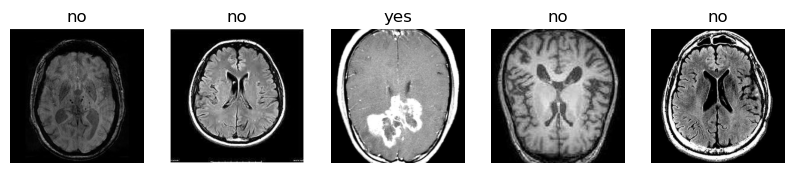

In [11]:
X_train, y_train = prepare_dataset(train_data)
X_val, y_val = prepare_dataset(val_data)
X_test, y_test = prepare_dataset(test_data)

show_sample_images(train_data, preprocess_image)


print(f"Total images excluded: {excluded_images_count}")
print(f"all images : {all_images}")

# Custom Model

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu, input_shape=(224, 224, 3)),  # Adjusted input shape
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()
# Model Compilation
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model Training using Validation Data
history = model.fit(X_train, y_train, batch_size=16, epochs=5, verbose=1, validation_data=(X_val, y_val))


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 56, 56, 32)        0         
                                                                 
 flatten_2 (Flatten)         (None, 100352)           

Text(0.5, 1.0, 'Loss over Epochs')

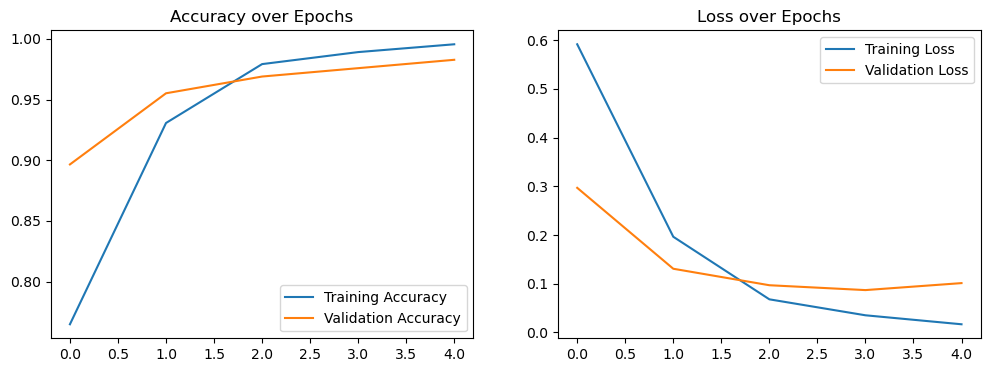

In [16]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')

In [17]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    gradcam = Gradcam(model, model_modifier=None, clone=False)
    cam = gradcam(
        lambda output: output[pred_index] if pred_index else output,
        img_array,
        penultimate_layer=-1,
    )
    heatmap = normalize(cam)
    return heatmap

In [18]:
def show_images_with_heatmaps(image_paths, model, preprocess_func, last_conv_layer_name):
    plt.figure(figsize=(10, 10))

    for i, image_path in enumerate(image_paths):
        # Original image
        original_img = preprocess_func(image_path, (224, 224))
        ax = plt.subplot(5, 2, 2 * i + 1)
        plt.imshow(original_img)
        plt.title(f"Original - {image_path.split('/')[-1]}")
        plt.axis('off')

        img_array = np.array([original_img])
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
        ax = plt.subplot(5, 2, 2 * i + 2)
        plt.imshow(original_img)
        plt.imshow(heatmap.squeeze(), cmap='jet', alpha=0.5)  
        plt.title("Heatmap")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

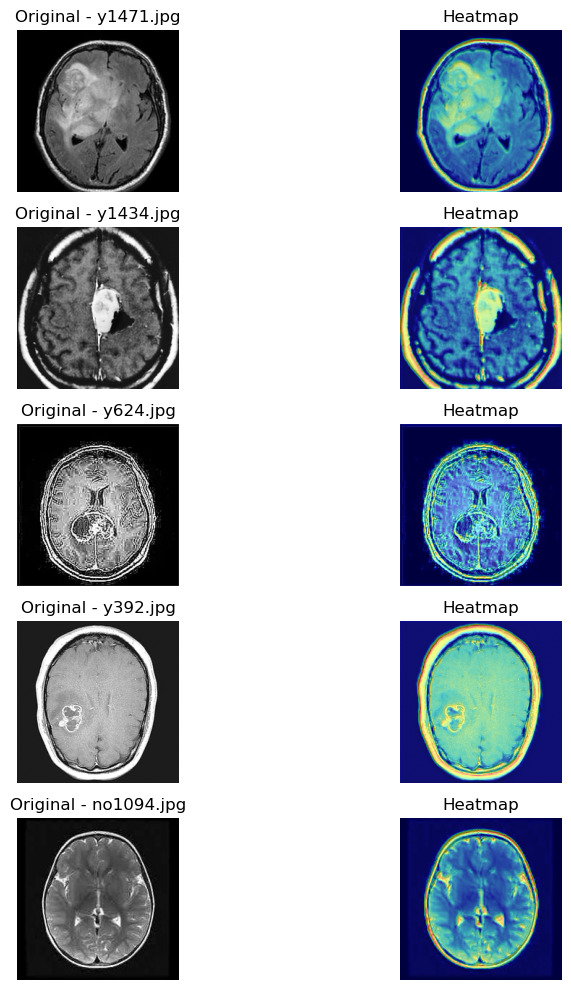

In [19]:
image_paths = [
    './data/yes/y1471.jpg',
    './data/yes/y1434.jpg',
    './data/yes/y624.jpg',
    './data/yes/y392.jpg',
    './data/no/no1094.jpg'
]

show_images_with_heatmaps(image_paths, model, preprocess_image, 'conv2d_5')

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# VGG16 Model

In [ ]:
# Load VGG16 pre-trained on ImageNet data
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze the base_model
base_model.trainable = False

# Add custom layers on top of VGG16 base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, batch_size=16, epochs=5, verbose=1, validation_data=(X_val, y_val))

# Use Grad-CAM
show_images_with_heatmaps(image_paths, model, preprocess_image, 'block5_conv3')


# Classification Model

# Data Loading

In [2]:
def display_image(image_path):
    img = Image.open(image_path)
    img.show()

giloma_path = './data/classification_data/giloma'
meningioma_path = "./data/classification_data/meningioma"
pituitary_path = "./data/classification_data/pituitary"
no_tumor_path = "./data/classification_data/notumor"

In [3]:
def create_dataframe(giloma_path, meningioma_path, pituitary_path, no_tumor_path):
    # Initialize an empty list to store the data
    data = []

    # Process 'giloma' images
    for image in os.listdir(giloma_path):
        data.append({
            "image_path": os.path.join(giloma_path, image),
            "tumor_type": "giloma"
        })

    # Process 'meningioma' images
    for image in os.listdir(meningioma_path):
        data.append({
            "image_path": os.path.join(meningioma_path, image),
            "tumor_type": "meningioma"
        })
        
    # Process 'pituitary' images
    for image in os.listdir(pituitary_path):
        data.append({
            "image_path": os.path.join(pituitary_path, image),
            "tumor_type": "pituitary"
        })

    # Process 'no tumor' images
    for image in os.listdir(no_tumor_path):
        data.append({
            "image_path": os.path.join(no_tumor_path, image),
            "tumor_type": "no tumor"
        })

    # Create a DataFrame
    df = pd.DataFrame(data)

    return df

# Train, Test, Validation Splits

In [4]:
def create_train_test_val_splits(df, test_size=0.2, val_size=0.1):

    # First, split into training + validation and test sets
    train_val_df, test_df = train_test_split(df, test_size=test_size, random_state=42)

    # Adjust val_size to compensate for the initial split
    adjusted_val_size = val_size / (1 - test_size)

    # Then, split the training + validation set into training and validation sets
    train_df, val_df = train_test_split(train_val_df, test_size=adjusted_val_size, random_state=42)

    return train_df, val_df, test_df

In [5]:
total_data = create_dataframe(giloma_path, meningioma_path, pituitary_path, no_tumor_path)
total_data = total_data.sample(frac=1).reset_index(drop=True)

In [6]:
# Shuffle and split the data
train_data, val_data, test_data = create_train_test_val_splits(total_data)

# Display the sizes of each set
print(f"Training Set: {len(train_data)}")
print(f"Validation Set: {len(val_data)}")
print(f"Test Set: {len(test_data)}")

print(train_data.head())

Training Set: 4915
Validation Set: 703
Test Set: 1405
                                             image_path  tumor_type
5117  ./data/classification_data/pituitary/Tr-pi_072...   pituitary
2727  ./data/classification_data/meningioma/Tr-me_06...  meningioma
6133   ./data/classification_data/giloma/Te-gl_0195.jpg      giloma
908   ./data/classification_data/meningioma/Tr-me_13...  meningioma
953    ./data/classification_data/giloma/Tr-gl_0647.jpg      giloma


# Make images the same size and normalize

We use the preprocessing code provided by the dataset: 
https://github.com/masoudnick/Brain-Tumor-MRI-Classification/blob/main/Preprocessing.py

In [7]:
# Global counter for images that are excluded
excluded_images_count = 0
all_images = 0

# Using preprocessing code provided with the dataset
def preprocess_image(image_path, image_size=(256,256)):
    global excluded_images_count
    global all_images
    all_images += 1

    try:
        img = cv2.imread(image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (3, 3), 0)
        
        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)
        
        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)
        
        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])
        ADD_PIXELS = 0
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        new_img = cv2.resize(new_img, image_size)
        return new_img
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        excluded_images_count += 1
        return None
    
def encode_label(label):
    if label == "giloma":
        return 1
    elif label == "meningioma":
        return 2
    elif label == "pituitary":
        return 3
    else:
        return 0
    
def prepare_dataset(df):
    images = df['image_path'].apply(lambda x: preprocess_image(x)).dropna()
    labels = df['tumor_type'][images.index].apply(encode_label)  # Align labels with images
    return np.array(images.tolist()), np.array(labels)

In [8]:
def show_sample_images(data, preprocess_func, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        img = preprocess_func(data.iloc[i]['image_path'])
        plt.imshow(img)
        plt.title(data.iloc[i]['tumor_type'])
        plt.axis("off")

Total images excluded: 0
all images : 7028


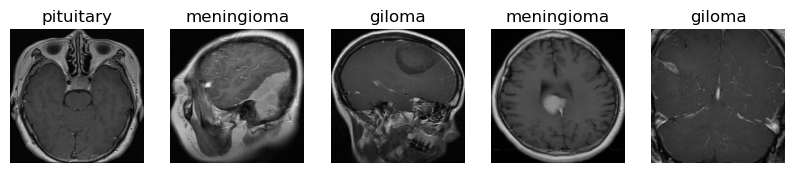

In [9]:
X_train, y_train = prepare_dataset(train_data)
X_val, y_val = prepare_dataset(val_data)
X_test, y_test = prepare_dataset(test_data)

show_sample_images(train_data, preprocess_image)


print(f"Total images excluded: {excluded_images_count}")
print(f"all images : {all_images}")

# Custom Model

In [11]:
num_classes = 4
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu, input_shape=(256, 256, 3)),  # Adjusted input shape
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Model Compilation
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model Training using Validation Data
history = model.fit(X_train, y_train, batch_size=16, epochs=5, verbose=1, validation_data=(X_val, y_val))

Epoch 1/5
308/308 [==============================] - 199s 640ms/step - loss: 52.8327 - accuracy: 0.5270 - val_loss: 0.9479 - val_accuracy: 0.6159
Epoch 2/5
308/308 [==============================] - 191s 618ms/step - loss: 0.7657 - accuracy: 0.7027 - val_loss: 0.7169 - val_accuracy: 0.6999
Epoch 3/5
308/308 [==============================] - 194s 629ms/step - loss: 0.6003 - accuracy: 0.7723 - val_loss: 0.6196 - val_accuracy: 0.7639
Epoch 4/5
308/308 [==============================] - 180s 585ms/step - loss: 0.4463 - accuracy: 0.8332 - val_loss: 0.7055 - val_accuracy: 0.7653
Epoch 5/5
308/308 [==============================] - 193s 627ms/step - loss: 0.3112 - accuracy: 0.8818 - val_loss: 0.4777 - val_accuracy: 0.8350


Text(0.5, 1.0, 'Loss over Epochs')

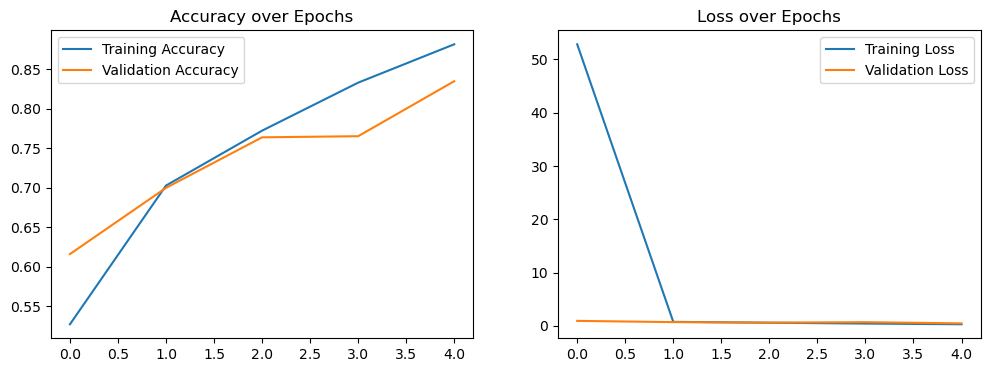

In [12]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')